AttributeError: module 'warnings' has no attribute 'filterWarnings'


Cross-Validation Scores: [0.9095659050470246, 0.9111192702008077, 0.9079842968904454, 0.9100717392532339, 0.9076710162119415]
Mean CV Score: 0.9092824455206907

Train Accuracy: 0.9220145396620969
Validation Accuracy: 0.9080638966085994

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     13062
           1       0.88      0.93      0.90     16938
           2       0.91      0.82      0.86      7492
           3       0.97      0.95      0.96      6767

    accuracy                           0.91     44259
   macro avg       0.92      0.90      0.91     44259
weighted avg       0.91      0.91      0.91     44259



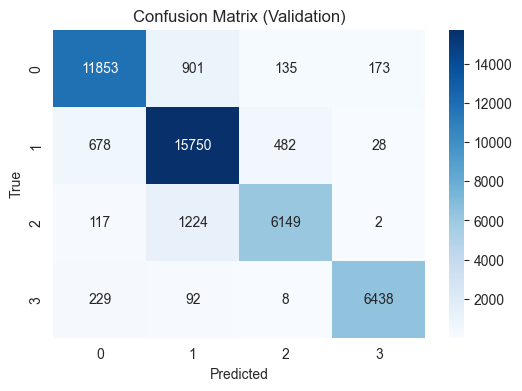

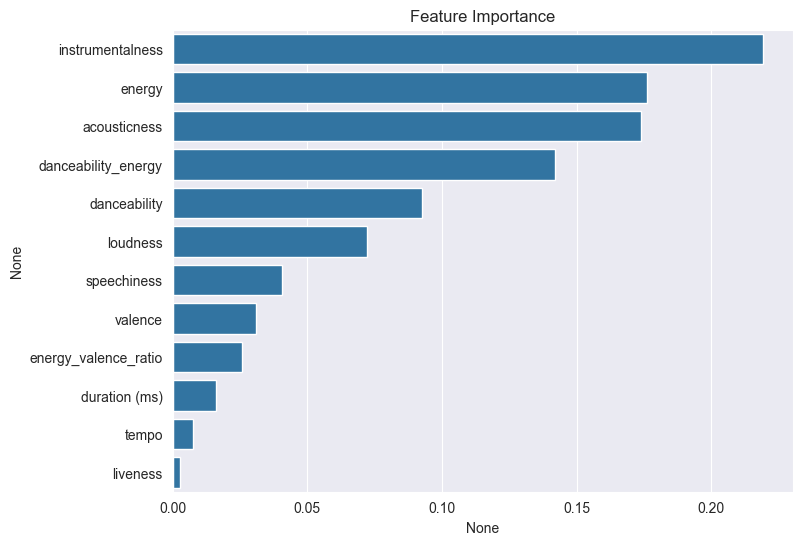

In [2]:
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.16.3
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

# # Jupyter Playbook: Moodify Data Hack
#
# This notebook follows the **Playbook Data Hack** for the [Moodify Dataset](https://www.kaggle.com/datasets/abdullahorzan/moodify-dataset) Kaggle competition. The goal is to predict song emotions (labels 0–3) using audio features. We aim for both high accuracy and learning insights, as outlined in the playbook.

# ## 1. Load and Inspect Dataset
#
# **Process**: Load `278_labelled_uri_train.csv` into a Pandas DataFrame, inspect its structure, and verify data integrity.
#
# **Why**: Ensures we understand the data (shape, columns, types) before preprocessing.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# Load dataset (Kaggle-compatible path)
try:
    df = pd.read_csv('/kaggle/input/moodify-dataset/278_labelled_uri_train.csv')
except FileNotFoundError:
    df = pd.read_csv('278_labelled_uri_train.csv')

# Inspect dataset
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
df.info()
print("\nFirst 5 Rows:")
print(df.head())

# ## 2. Preprocess Data
#
# **Process**: Drop irrelevant columns, handle duplicates, check for null values, and extract labels.
#
# **Why**: Creates a clean dataset for analysis and modeling. Dropping `spec_rate` is justified by its low variance (observed in preliminary analysis).

# Drop columns
columns_to_drop = ['anonymous', 'uri', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2', 'spec_rate']
df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

# Remove duplicates
print("\nDuplicates Before:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Duplicates After:", df.duplicated().sum())

# Check null values
print("\nNull Values:")
print(df.isnull().sum())

# Extract labels and features
y = df['labels']
X = df.drop('labels', axis=1)

print("\nFeatures Shape:", X.shape)
print("Labels Shape:", y.shape)
print("Remaining Columns:", X.columns.tolist())

# ## 3. Feature Analysis
#
# **Process**: Visualize feature distributions, correlations, and label distribution. Check for outliers.
#
# **Why**: Understands feature relationships, identifies potential issues (e.g., imbalance, outliers), and guides feature engineering.

# ### 3.1 Feature Distributions
fig = make_subplots(
    rows=4, cols=3,
    subplot_titles=X.columns.tolist()
)
for i, col in enumerate(X.columns):
    fig.add_trace(go.Histogram(x=X[col], name=col), row=(i//3)+1, col=(i%3)+1)
fig.update_layout(height=800, title_text="Feature Distributions")
fig.show()

# ### 3.2 Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# ### 3.3 Label Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Label Distribution')
plt.xlabel('Emotion Labels (0-3)')
plt.show()
print("\nLabel Distribution (%):")
print(y.value_counts(normalize=True) * 100)

# ### 3.4 Outlier Detection (IQR Method)
outliers = {}
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = (X[col] < (Q1 - 1.5 * IQR)) | (X[col] > (Q3 + 1.5 * IQR))
    outliers[col] = outlier_mask.sum()
print("\nOutliers per Feature:")
print(pd.Series(outliers))

# **Note**: Outliers are identified but not removed yet. We’ll test model performance with and without outlier removal later.

# ## 4. Feature Engineering
#
# **Process**: Create new features to capture interactions between existing ones.
#
# **Why**: Enhances model performance by providing more informative features.

# Create new features
X['energy_valence_ratio'] = X['energy'] / (X['valence'] + 1e-5)  # Avoid division by zero
X['danceability_energy'] = X['danceability'] * X['energy']

print("\nNew Features Added:", X.columns.tolist())

# ## 5. Model Preparation
#
# **Process**: Split data, scale features, and prepare for cross-validation.
#
# **Why**: Ensures data is ready for training and evaluation, preventing data leakage.

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\nTrain Shape:", X_train_scaled.shape)
print("Validation Shape:", X_val_scaled.shape)

# ## 6. Model Training and Evaluation
#
# **Process**: Train a Random Forest model with cross-validation, evaluate performance, and check for overfitting.
#
# **Why**: Validates model quality and identifies issues like overfitting.

# Initialize model with regularization to reduce overfitting
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for train_idx, val_idx in kf.split(X_train_scaled):
    model.fit(X_train_scaled[train_idx], y_train.iloc[train_idx])
    y_pred = model.predict(X_train_scaled[val_idx])
    cv_scores.append(accuracy_score(y_train.iloc[val_idx], y_pred))
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

# Train on full training set
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_train = model.predict(X_train_scaled)
y_pred_val = model.predict(X_val_scaled)

print("\nTrain Accuracy:", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_pred_val))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_val), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.show()

# ## 7. Next Steps
#
# **Process**: Outline future improvements and submission preparation.
#
# **Why**: Guides iterative experimentation and prepares for Kaggle submission.

# ### Improvements
# - Try XGBoost or other models.
# - Tune hyperparameters using GridSearchCV.
# - Handle outliers (e.g., remove or cap).
# - Address class imbalance if present (e.g., SMOTE).
# - Test removing low-importance features.

# ### Kaggle Submission (Placeholder)
# ```python
# # Load test set
# df_test = pd.read_csv('/kaggle/input/moodify-dataset/278_labelled_uri_test.csv')
# uri_test = df_test['uri']  # Save for submission
# df_test.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')
#
# # Apply feature engineering
# df_test['energy_valence_ratio'] = df_test['energy'] / (df_test['valence'] + 1e-5)
# df_test['danceability_energy'] = df_test['danceability'] * df_test['energy']
#
# # Scale features
# X_test_scaled = scaler.transform(df_test)
#
# # Predict
# y_test_pred = model.predict(X_test_scaled)
#
# # Create submission
# submission = pd.DataFrame({'uri': uri_test, 'labels': y_test_pred})
# submission.to_csv('submission.csv', index=False)
# ```

# **Note**: Uncomment and adjust the submission code when the test set is available.